Prep work:

*   Download student csv predictions from I-Learn
*   Rename files to team8-module4-predictions.csv where team8 is the name of the team
*   Make sure file is one column and remove any extra columns
*   Make sure the heading is set to "predictions" (without quotes)
*   Upload student csv predictions to session storage area.
*   Upload module4-holdout-answers.csv found in the Canvas module (DO NOT SHARE THIS FILE)
*   Run the notebook






In [107]:
# MODULE 04 - BIKING HOLDOUT GRADING

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

# THESE DETERMINE THE AUTO GRADER PARAMETER AND RANGES FOR 100 AND 0
grading_criteria = 'R2'
level_for_top_score = .84
level_for_bottom_score = .65

# READ IN THE CSV FILES
team_dir = Path("./")
teams = team_dir.glob("*-predictions.csv")
team_list = []
for team in teams:
  # print(latent_file)
  team_list.append((str(team).split("-",1)[0],team))

print(team_list)

[('team1v1', PosixPath('team1v1-module4-predictions.csv')), ('team10v2', PosixPath('team10v2-module4-predictions.csv')), ('team6', PosixPath('team6-module4-predictions.csv')), ('test2', PosixPath('test2-module4-predictions.csv')), ('test3', PosixPath('test3-module4-predictions.csv')), ('team2', PosixPath('team2-module4-predictions.csv')), ('team3', PosixPath('team3-module4-predictions.csv')), ('team1', PosixPath('team1-module4-predictions.csv')), ('teamadam', PosixPath('teamadam-module4-predictions.csv')), ('team4', PosixPath('team4-module4-predictions.csv')), ('team7', PosixPath('team7-module4-predictions.csv')), ('team5', PosixPath('team5-module4-predictions.csv')), ('team9', PosixPath('team9-module4-predictions.csv')), ('team8', PosixPath('team8-module4-predictions.csv')), ('team10v3', PosixPath('team10v3-module4-predictions.csv'))]


In [108]:
# READ IN THE HOLDOUT ANSWERS
targets_file = "module4-holdout-answers.csv"
targets = pd.read_csv(targets_file)
targets['actual'] = targets.casual + targets.registered
targets.drop(columns=['casual','registered'],inplace=True)
# targets

,actual
0,108
1,69
2,50
3,15
4,5
...,...
737,119
738,89
739,90
740,61


In [109]:
# ARE THE STUDENT DATASETS THE CORRECT LENGTH
student_datasets = {}
for (group, file) in team_list:
  ds = pd.read_csv(file)
  
  if ds.shape != targets.shape:
    print(f"Error group {group} ds had {ds.shape} rows and columns instead of the expected {targets.shape}. It will be excluded.")
  else:
    student_datasets[group] = ds
    print(f"Group {group} added successfully")

Group team1v1 added successfully
Error group team10v2 ds had (16637, 1) rows and columns instead of the expected (742, 1). It will be excluded.
Group team6 added successfully
Group test2 added successfully
Group test3 added successfully
Group team2 added successfully
Group team3 added successfully
Group team1 added successfully
Group teamadam added successfully
Group team4 added successfully
Group team7 added successfully
Group team5 added successfully
Group team9 added successfully
Group team8 added successfully
Group team10v3 added successfully


In [110]:
# student_datasets

{'team1':      predictions
 0     108.970970
 1      88.768090
 2      56.349630
 3      24.731403
 4      10.538908
 ..           ...
 737   256.148680
 738   216.282290
 739   180.329210
 740   135.956480
 741    49.795284
 
 [742 rows x 1 columns], 'team10v3':      prediction
 0     59.349224
 1     98.635810
 2     38.517180
 3     21.308397
 4      5.327889
 ..          ...
 737  160.221860
 738  112.419876
 739   87.826640
 740   77.909610
 741   42.896080
 
 [742 rows x 1 columns], 'team1v1':      predictions
 0      24.352770
 1      17.667305
 2      11.109496
 3       5.484591
 4       6.035180
 ..           ...
 737   121.040180
 738    92.342160
 739    64.427550
 740    45.635350
 741    31.417780
 
 [742 rows x 1 columns], 'team2':               0
 0    167.052032
 1    166.778168
 2    166.839920
 3    166.335480
 4    166.588074
 ..          ...
 737  162.857284
 738  162.783386
 739  162.942795
 740  163.005493
 741  163.237030
 
 [742 rows x 1 columns], 'team3':      

In [111]:
def recommended_grade(amount):
  '''
  A simple min max scaler to identify a recommended score for the holdout set
  '''
  min_allowed = level_for_bottom_score
  max_allowed = level_for_top_score
  if amount>max_allowed:
    return 100
  elif amount<min_allowed:
    return 0
  else:
    return (amount - min_allowed) / (max_allowed - min_allowed)*100
    

In [112]:
results_dict = {}

In [113]:
for group, student_ds in student_datasets.items():
  student_dict = {}
  # print(group,cm)
  student_ds.columns=['predictions']
  mse = mean_squared_error(targets, student_ds, squared=False)
  # print("{} - RMSE: {}".format(group, mse))

  student_dict["RMSE"] = mean_squared_error(targets, student_ds, squared=False)
  student_dict["Mean Abs Error"] = mean_absolute_error(targets, student_ds)
  student_dict["Median Abs Error"] = median_absolute_error(targets, student_ds)
  student_dict["R2"] = r2_score(targets, student_ds)

  combined = pd.concat([targets, student_ds], axis=1)
  combined.columns = ["target", "pred"]
  combined["absdiff"] = (combined["target"] - combined["pred"]).abs()
  combined["absdiff_pct"] = combined["absdiff"] / combined["target"]

  shower = pd.DataFrame(student_ds, columns = ['predictions'])
  shower.columns = ['predictions']
  testfinal = pd.concat([shower,targets['actual']],axis=1)
  testfinal['difference'] = testfinal['actual']-testfinal['predictions']
  testfinal['percent_difference'] = abs(testfinal['difference']/testfinal['actual'])
  testfinal['percent_bucket'] = [ "above 20%" if i >= 0.2 else "below 20%" for i in testfinal.percent_difference ]
 
  # testfinal

  student_dict['dataset'] = testfinal
  percents = [5, 10, 20]
  for percent in percents:
    student_dict[f"Percent of bikes within {percent} percent"] = len(combined[combined["absdiff_pct"] <= (percent /100)]) / len(combined) * 100
  student_dict["Grade"] = recommended_grade(student_dict[grading_criteria])

  results_dict[group] = student_dict

In [114]:
# results_dict

{'team1': {'Grade': 100,
  'Mean Abs Error': 27.762095693867924,
  'Median Abs Error': 17.064669999999992,
  'Percent of bikes within 10 percent': 33.82749326145553,
  'Percent of bikes within 20 percent': 55.660377358490564,
  'Percent of bikes within 5 percent': 17.78975741239892,
  'R2': 0.9312790489568459,
  'RMSE': 43.19761065938243,
  'dataset':      predictions  actual  difference  percent_difference percent_bucket
  0     108.970970     108   -0.970970            0.008990      below 20%
  1      88.768090      69  -19.768090            0.286494      above 20%
  2      56.349630      50   -6.349630            0.126993      below 20%
  3      24.731403      15   -9.731403            0.648760      above 20%
  4      10.538908       5   -5.538908            1.107782      above 20%
  ..           ...     ...         ...                 ...            ...
  737   256.148680     119 -137.148680            1.152510      above 20%
  738   216.282290      89 -127.282290            1.4301

In [115]:
results_df = pd.DataFrame(results_dict)
results_ds_trans = results_df.transpose()
results_ds_trans = results_ds_trans.drop(columns=["Grade"])
results_ds_trans = results_ds_trans.drop(columns=["dataset"])

results_ds_trans = results_ds_trans.round(2)
results_ds_trans = results_ds_trans.sort_values(by="R2",ascending=False)


In [116]:
# results_df

-------------------------------- TEAM1V1 RESULTS ---------------------------------

 Within 5%: 3.638814016172507%
 Within 10%: 6.199460916442049%
 Within 20%: 14.285714285714285%
 R^2: 0.1972398725898955%
 RMSE: 147.64136163887798
 Mean Absolute Error: 94.04539767816712
 Median Aboslute Error: 46.59243


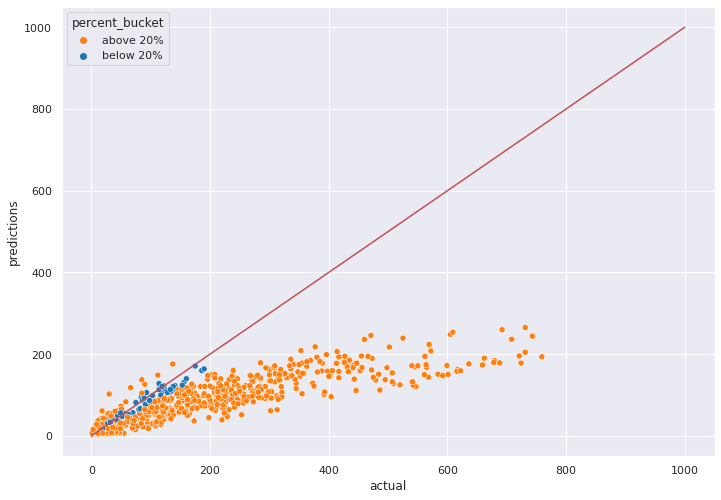

-----------------------------------------------------------------------------




-------------------------------- TEAM6 RESULTS ---------------------------------

 Within 5%: 8.221024258760108%
 Within 10%: 16.9811320754717%
 Within 20%: 32.34501347708895%
 R^2: 0.7352742367914076%
 RMSE: 84.78387264101923
 Mean Absolute Error: 54.58812226185984
 Median Aboslute Error: 31.165595000000025


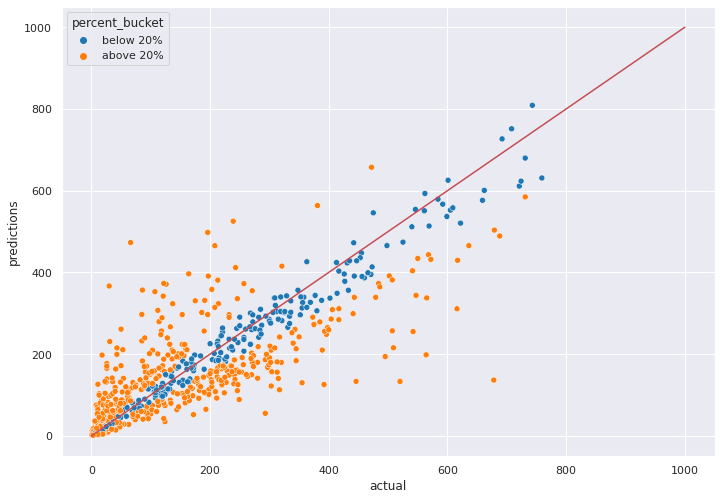

-----------------------------------------------------------------------------




-------------------------------- TEST2 RESULTS ---------------------------------

 Within 5%: 4.44743935309973%
 Within 10%: 9.029649595687331%
 Within 20%: 20.889487870619945%
 R^2: 0.622450942326646%
 RMSE: 101.251587370437
 Mean Absolute Error: 66.34144187654987
 Median Aboslute Error: 40.95404700000001


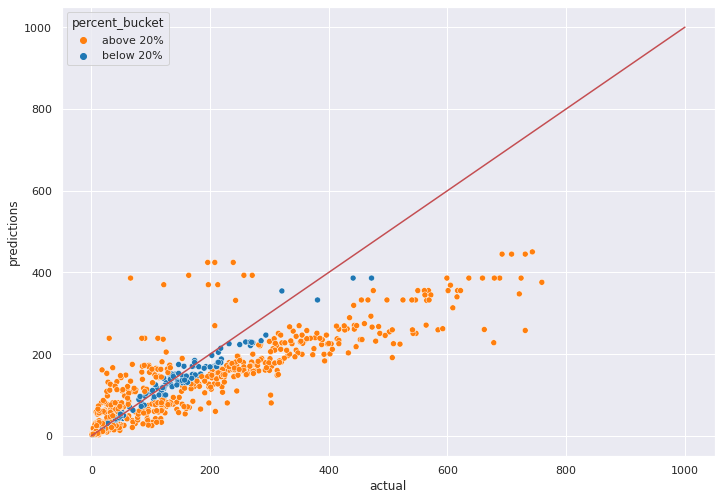

-----------------------------------------------------------------------------




-------------------------------- TEST3 RESULTS ---------------------------------

 Within 5%: 6.46900269541779%
 Within 10%: 12.398921832884097%
 Within 20%: 25.471698113207548%
 R^2: 0.5966991898099467%
 RMSE: 104.64770117035536
 Mean Absolute Error: 66.19501204487871
 Median Aboslute Error: 39.65761799999999


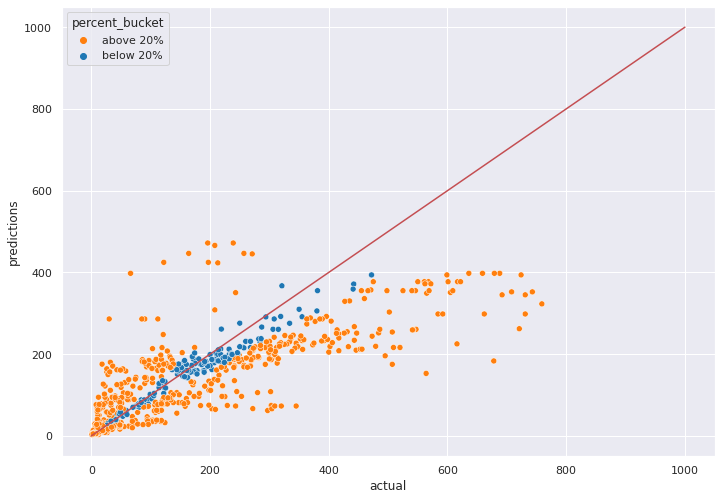

-----------------------------------------------------------------------------




-------------------------------- TEAM2 RESULTS ---------------------------------

 Within 5%: 3.7735849056603774%
 Within 10%: 6.199460916442049%
 Within 20%: 11.455525606469003%
 R^2: 0.003889981380434615%
 RMSE: 164.46322391678322
 Mean Absolute Error: 129.65161428827494
 Median Aboslute Error: 122.69908145000001


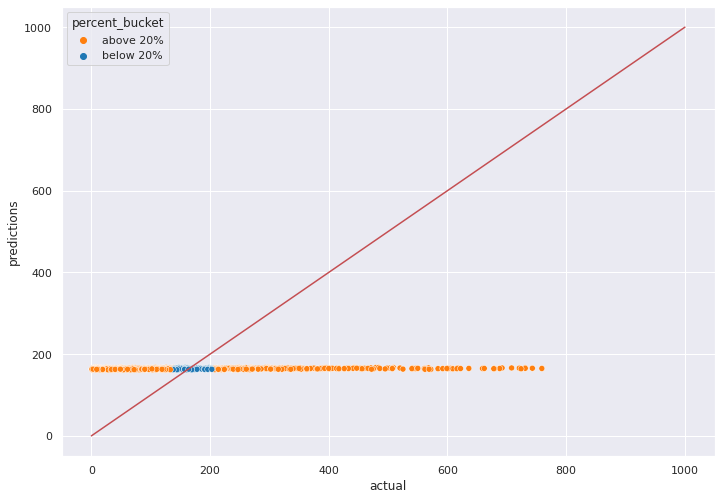

-----------------------------------------------------------------------------




-------------------------------- TEAM3 RESULTS ---------------------------------

 Within 5%: 11.320754716981133%
 Within 10%: 21.69811320754717%
 Within 20%: 38.14016172506739%
 R^2: 0.8470612270331344%
 RMSE: 64.44273234103025
 Mean Absolute Error: 44.07394279838275
 Median Aboslute Error: 27.310700000000004


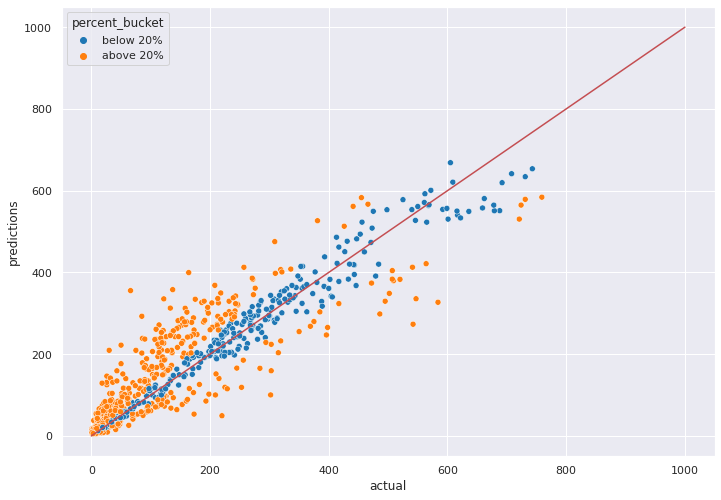

-----------------------------------------------------------------------------




-------------------------------- TEAM1 RESULTS ---------------------------------

 Within 5%: 17.78975741239892%
 Within 10%: 33.82749326145553%
 Within 20%: 55.660377358490564%
 R^2: 0.9312790489568459%
 RMSE: 43.19761065938243
 Mean Absolute Error: 27.762095693867924
 Median Aboslute Error: 17.064669999999992


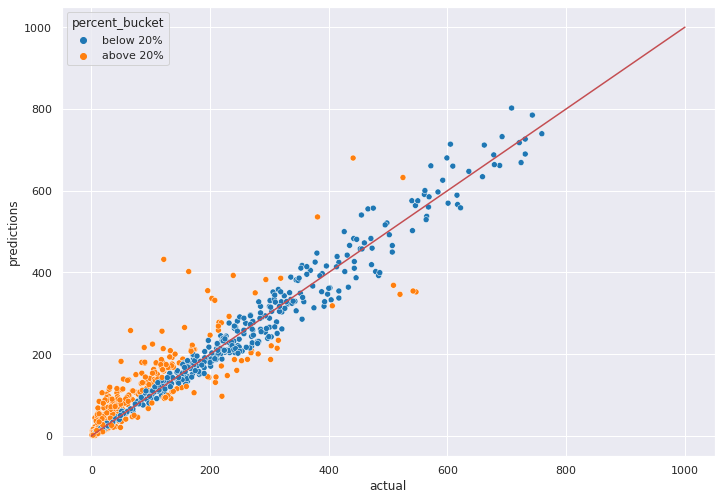

-----------------------------------------------------------------------------




-------------------------------- TEAMADAM RESULTS ---------------------------------

 Within 5%: 12.129380053908356%
 Within 10%: 23.71967654986523%
 Within 20%: 44.474393530997304%
 R^2: 0.8638214829079381%
 RMSE: 60.809221796744005
 Mean Absolute Error: 39.63477088948787
 Median Aboslute Error: 23.0


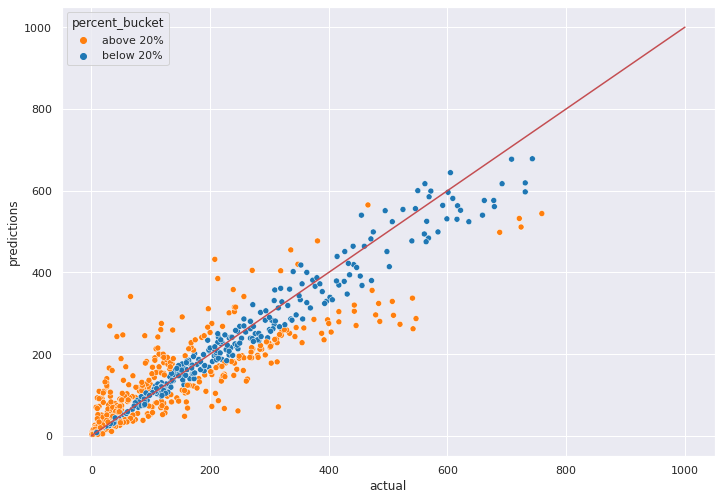

-----------------------------------------------------------------------------




-------------------------------- TEAM4 RESULTS ---------------------------------

 Within 5%: 1.2129380053908356%
 Within 10%: 2.4258760107816713%
 Within 20%: 6.334231805929918%
 R^2: -0.9539988067534839%
 RMSE: 230.34420585077078
 Mean Absolute Error: 201.4739780902965
 Median Aboslute Error: 191.36142


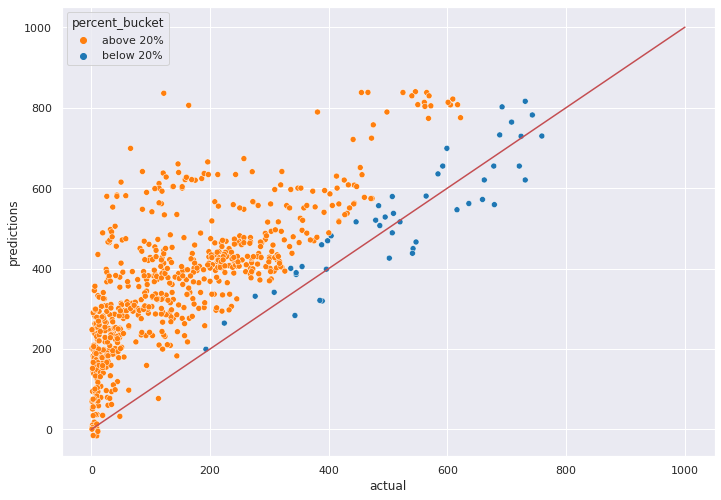

-----------------------------------------------------------------------------




-------------------------------- TEAM7 RESULTS ---------------------------------

 Within 5%: 6.873315363881402%
 Within 10%: 13.881401617250674%
 Within 20%: 33.55795148247979%
 R^2: 0.8126824354487121%
 RMSE: 71.31886065588311
 Mean Absolute Error: 47.59563512587601
 Median Aboslute Error: 27.457081999999996


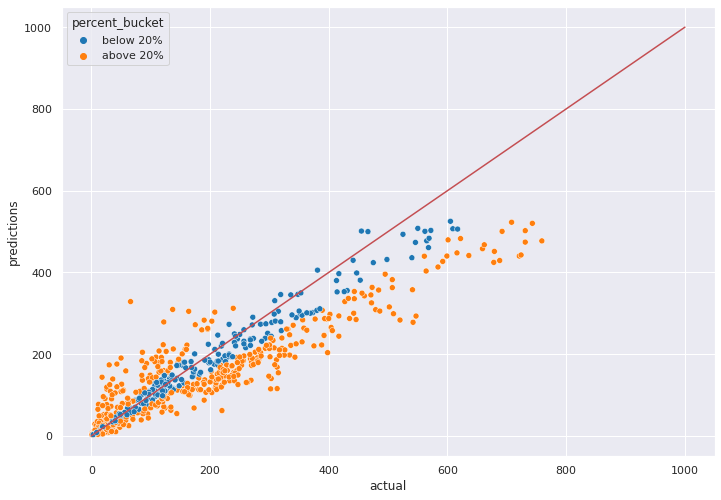

-----------------------------------------------------------------------------




-------------------------------- TEAM5 RESULTS ---------------------------------

 Within 5%: 11.590296495956872%
 Within 10%: 22.911051212938006%
 Within 20%: 41.77897574123989%
 R^2: 0.8074526977613778%
 RMSE: 72.30758625760708
 Mean Absolute Error: 45.27922061380054
 Median Aboslute Error: 26.233198


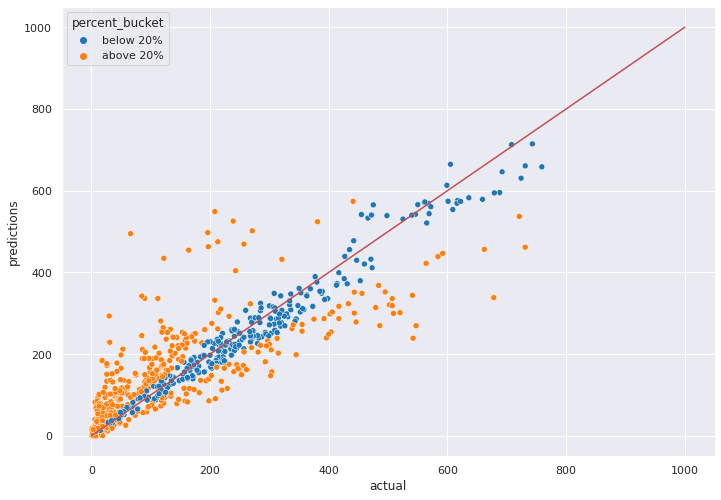

-----------------------------------------------------------------------------




-------------------------------- TEAM9 RESULTS ---------------------------------

 Within 5%: 5.525606469002695%
 Within 10%: 12.668463611859837%
 Within 20%: 25.87601078167116%
 R^2: 0.8096650093117387%
 RMSE: 71.89098976849492
 Mean Absolute Error: 51.263605700107824
 Median Aboslute Error: 36.763991835


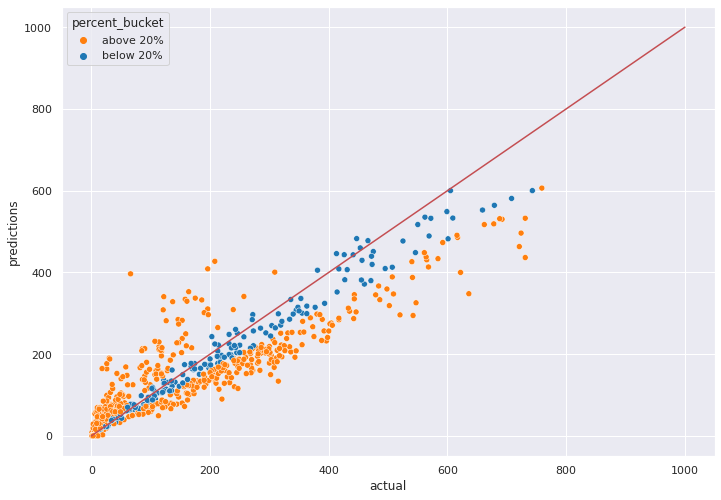

-----------------------------------------------------------------------------




-------------------------------- TEAM8 RESULTS ---------------------------------

 Within 5%: 11.859838274932615%
 Within 10%: 23.71967654986523%
 Within 20%: 40.8355795148248%
 R^2: 0.7598834763245823%
 RMSE: 80.74695777973366
 Mean Absolute Error: 52.31746608262804
 Median Aboslute Error: 30.49007499999999


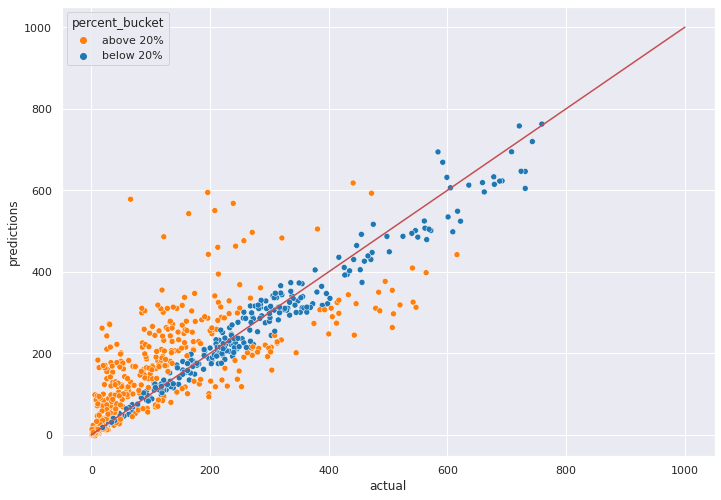

-----------------------------------------------------------------------------




-------------------------------- TEAM10V3 RESULTS ---------------------------------

 Within 5%: 7.816711590296496%
 Within 10%: 14.555256064690028%
 Within 20%: 29.245283018867923%
 R^2: 0.7252433555720592%
 RMSE: 86.37523602875049
 Mean Absolute Error: 54.68512759792452
 Median Aboslute Error: 29.90523000000001


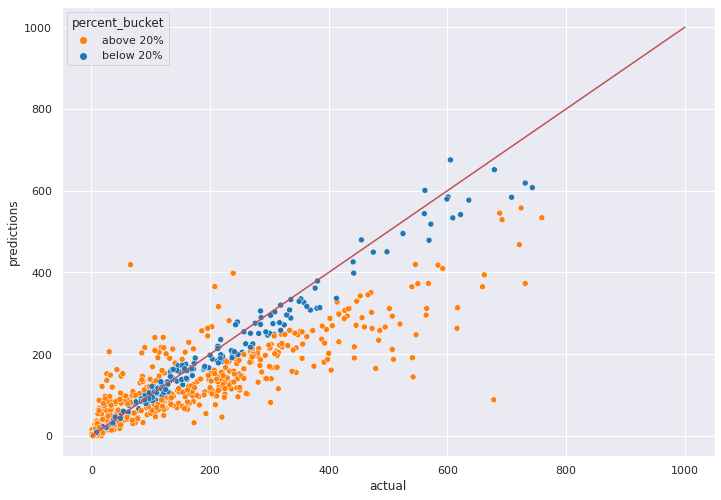

-----------------------------------------------------------------------------






In [117]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
for team_results in results_dict.items():
  testfinal = team_results[1]['dataset']
  # print(team_results['dataset'])
  # print(f"R-Squared Value: {r2}")
  print(f"-------------------------------- {team_results[0].upper()} RESULTS ---------------------------------\n")
  print(f" Within 5%: {team_results[1]['Percent of bikes within 5 percent']}%\n",
  f"Within 10%: {team_results[1]['Percent of bikes within 10 percent']}%\n",
  f"Within 20%: {team_results[1]['Percent of bikes within 20 percent']}%\n",
  f"R^2: {team_results[1]['R2']}%\n",
  f"RMSE: {team_results[1]['RMSE']}\n",
  f"Mean Absolute Error: {team_results[1]['Mean Abs Error']}\n",
  f"Median Aboslute Error: {team_results[1]['Median Abs Error']}")


  color_dict = dict({'below 20%':'tab:blue',
                    'above 20%': 'tab:orange'})
  # print(testfinal['abspercentmiss'].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]))
  xlims=(0,1e3)
  # ylims=(0,1e3)
  ax = sns.scatterplot(data=testfinal,x='actual',y='predictions',hue="percent_bucket",palette=color_dict)
  # ax.set(xscale="log", yscale="log", xlim=xlims, ylim=ylims)
  ax.plot(xlims,xlims, color='r')
  # plt.legend(labels=['perfect',"below 5",'above 5','10-20%','above 20'])  
  plt.show()
  print(f"-"*77)
  print("\n"*3)


In [ ]:
pd.set_option('mode.chained_assignment',None)
sns.set(rc={'figure.figsize':(20,6)})
for team_results in results_dict.items():
  print(f"-------------------------------- {team_results[0].upper()} RESULTS ---------------------------------\n")
  testfinal = team_results[1]['dataset']
  testfinal = testfinal[['actual', 'predictions']]
  testfinal['i'] = testfinal.index
  testfinal=testfinal.melt(['i'])

  ax = sns.lineplot(data=testfinal,x='i',y='value',hue='variable')

  plt.show()
  print(f"-"*77)
  print("\n"*3)

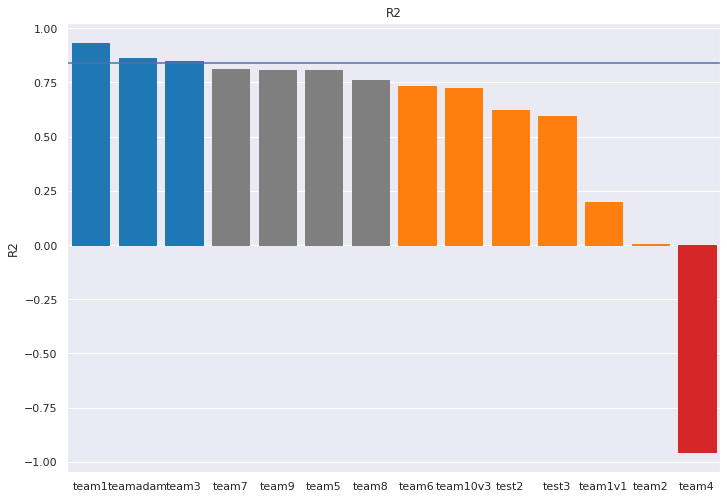

,RMSE,Mean Abs Error,Median Abs Error,R2,Percent of bikes within 5 percent,Percent of bikes within 10 percent,Percent of bikes within 20 percent
team1,43.1976,27.7621,17.0647,0.931279,17.7898,33.8275,55.6604
teamadam,60.8092,39.6348,23,0.863821,12.1294,23.7197,44.4744
team3,64.4427,44.0739,27.3107,0.847061,11.3208,21.6981,38.1402
team7,71.3189,47.5956,27.4571,0.812682,6.87332,13.8814,33.558
team9,71.891,51.2636,36.764,0.809665,5.52561,12.6685,25.876
team5,72.3076,45.2792,26.2332,0.807453,11.5903,22.9111,41.779
team8,80.747,52.3175,30.4901,0.759883,11.8598,23.7197,40.8356
team6,84.7839,54.5881,31.1656,0.735274,8.22102,16.9811,32.345
team10v3,86.3752,54.6851,29.9052,0.725243,7.81671,14.5553,29.2453
test2,101.252,66.3414,40.954,0.622451,4.44744,9.02965,20.8895


In [118]:
# GENERATE GRAPHICS FOR TEAMS 
# THESE CAN BE SHARED WITH THE STUDENTS

graph = sns.barplot(data=results_ds_trans,y=grading_criteria,x=results_ds_trans.index)
graph.set_title(grading_criteria)
graph.axhline(level_for_top_score)
for bar in graph.patches:
    if bar.get_height() >= level_for_top_score:
        bar.set_color('tab:blue') 
    elif bar.get_height() <0:
      bar.set_color('tab:red')         
    elif bar.get_height() < level_for_bottom_score:
      bar.set_color('tab:orange')  
    else:
        bar.set_color('tab:grey')
#The plot is shown
plt.show()
results_ds_trans

In [119]:
results_ds_trans = results_df.transpose()

results_ds_trans = results_ds_trans.drop(columns=["dataset"])
results_ds_trans = results_ds_trans.sort_values(by=grading_criteria,ascending=False)
results_ds_trans.to_csv("class_results.csv")
results_ds_trans

,RMSE,Mean Abs Error,Median Abs Error,R2,Percent of bikes within 5 percent,Percent of bikes within 10 percent,Percent of bikes within 20 percent,Grade
team1,43.1976,27.7621,17.0647,0.931279,17.7898,33.8275,55.6604,100
teamadam,60.8092,39.6348,23,0.863821,12.1294,23.7197,44.4744,100
team3,64.4427,44.0739,27.3107,0.847061,11.3208,21.6981,38.1402,100
team7,71.3189,47.5956,27.4571,0.812682,6.87332,13.8814,33.558,69.6472
team9,71.891,51.2636,36.764,0.809665,5.52561,12.6685,25.876,66.2945
team5,72.3076,45.2792,26.2332,0.807453,11.5903,22.9111,41.779,63.8363
team8,80.747,52.3175,30.4901,0.759883,11.8598,23.7197,40.8356,10.9816
team6,84.7839,54.5881,31.1656,0.735274,8.22102,16.9811,32.345,0
team10v3,86.3752,54.6851,29.9052,0.725243,7.81671,14.5553,29.2453,0
test2,101.252,66.3414,40.954,0.622451,4.44744,9.02965,20.8895,0
